In [1]:
import torch
import torch.nn.functional as Func
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [43]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p, decay):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [44]:
def uncertainity_estimate(X, model, iters, l2):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - model.dropout_p) / (2. * N * model.decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [45]:
def fit_model(model, optimizer):
    Y = Variable(torch.Tensor(y[:, np.newaxis]), requires_grad=False)
    y_pred = model(x[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, Y)
    loss.backward()
    optimizer.step()
    return loss

## Testing w/ default code

In [65]:
def get_data(N, min_x= -10., max_x=10.):    
    np.random.seed(1)
    def true_model(x):
        noise = np.random.normal(loc = 10, scale = 80, size = N)
        y =  x**3 + noise
        return y
    X_obs = np.linspace(min_x, max_x, N)
    y_obs = true_model(X_obs)
    X_true = np.linspace(min_x - 10, max_x + 10, 100)
    return X_obs, y_obs, X_true

In [67]:
N = 100 ##  number of points
l2 = 0.01
X_obs, y_obs, X_true = get_data(N)
# Normalise data:
X_mean, X_std = X_obs.mean(), X_obs.std()
y_mean, y_std = y_obs.mean(), y_obs.std()
X_obs = (X_obs - X_mean) / X_std
y_obs = (y_obs - y_mean) / y_std
X_true = (X_true - X_mean) / X_std

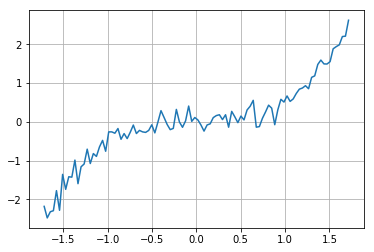

In [68]:
plt.plot(X_obs, y_obs)
plt.grid()

In [70]:
model = SimpleModel(p=0.1, decay=1e-6)

In [81]:
def plot_model(model, l2, iters=200, n_std=3, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,1)
    y_mean, y_std = uncertainity_estimate(X_true, model, iters, l2)
    
    ax.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
    ax.plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax.fill_between(
            X_true,
            y_mean - y_std * ((i+1.)/2.),
            y_mean + y_std * ((i+1.)/2.),
            color="b",
            alpha=0.1
        )
    ax.legend()
    return ax

100%|██████████| 200/200 [00:00<00:00, 3882.66it/s]


<Figure size 432x288 with 0 Axes>

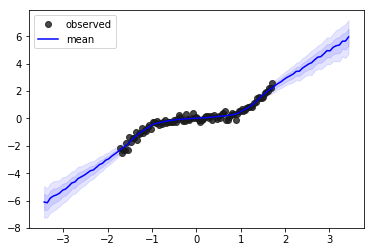

In [89]:
plot_model(model, l2, n_std=2)

In [83]:
criterion  = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.,
    weight_decay=model.decay)

In [84]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|██████████| 200/200 [00:00<00:00, 4478.30it/s]


loss=0.049875568598508835


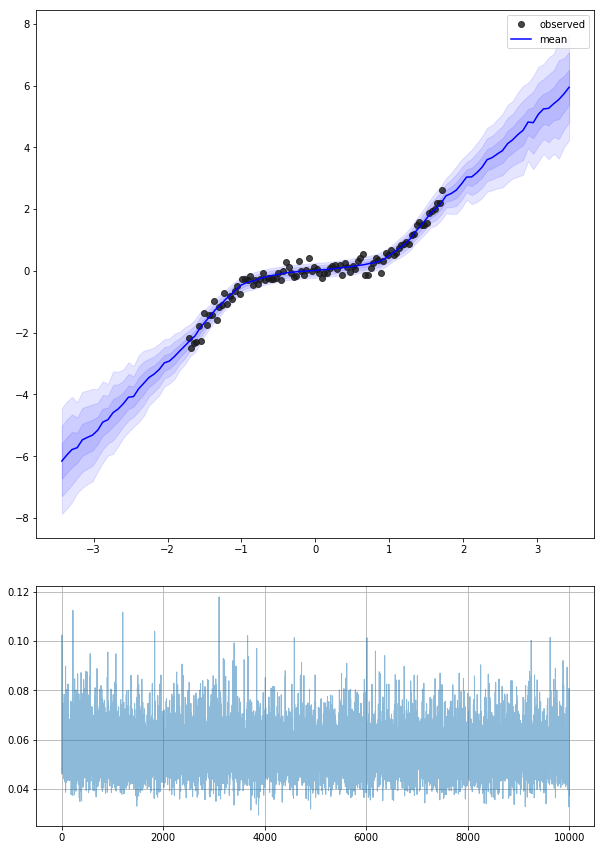

In [85]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = fit_model(model, optimizer)
    losses.append(loss.data.numpy())
print("loss={}".format(loss.data.numpy()))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
plot_model(model, l2, ax=ax0)
plt.grid()